In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from pyamg.gallery import stencil_grid
from scipy.sparse import diags, kron, eye

## Poisson BVP
Letting $\Omega = [0,1]^2 \subset \mathbb{R}^2$, given $f$,
the BVP is to solve for $u$ obeying

$$
-\Delta u = f \qquad \text{ in } \Omega,
$$

$$
u = 0 \qquad \text{ on } \partial\Omega.
$$
The eigenvalues of the coefficient matrix discretized by the five-point difference scheme are
\begin{equation}
    \lambda_{jx,jy}=\frac4{h_x^2}\sin\left(\frac{\pi j_x}{2(n_x+1)}\right)^2+\frac4{h_y^2}\sin\left(\frac{\pi j_y}{2(n_y+1)}\right)^2
\end{equation}
where  $j_x=1,\ldots,n_x,j_y=1,\ldots,n_y,$

and, eigenvectors are given by
$$v_{ix,iy,jx,jy}=\sqrt{\frac{2}{n_{x}+1}}\sin\biggl(\frac{i_{x}j_{x}\pi}{n_{x}+1}\biggr)\sqrt{\frac{2}{n_{y}+1}}\sin\biggl(\frac{i_{y}j_{y}\pi}{n_{y}+1}\biggr)$$
where the multi-index $jx,jy$ pairs the eigenvalues and the eigenvectors, while the multi-index $ix,iy$ determines the location
of the value of every eigenvector at the regular grid. 

Ref ：https://en.wikipedia.org/wiki/Kronecker_sum_of_discrete_Laplacians

In [2]:
def generate_eigvec(nx, ny, jx, jy):
    eigenvectors_matrix = np.zeros((nx*ny, 1))
    for ix in range(nx):
        for iy in range(ny):
            eigenvectors_matrix[ix*ny+iy, 0] = np.sqrt(2/(nx+1)) * np.sin((ix+1)*jx*np.pi/(nx+1)) * np.sqrt(2/(ny+1)) * np.sin((iy+1)*jy*np.pi/(ny+1))
    return eigenvectors_matrix

In [3]:
def generate_eigs(nx, ny, jx, jy):
    eig = (4*(nx+1)**2)*np.sin(jx*np.pi/(2*(nx+1)))**2 + (4*(ny+1)**2)*np.sin(jy*np.pi/(2*(ny+1)))**2
    return eig

In [4]:
def gen_A(n):
    h = 1/(n+1)
    ex = np.ones(n)
    Dxx = diags([-1*ex, 2*ex, -1*ex], [-1, 0, 1], shape=(n, n))  

    ey = np.ones(n)
    Dyy = diags([-1*ey, 2*ey, -1*ey], [-1, 0, 1], shape=(n, n))  

    A = (kron(Dyy, eye(n)) + kron(eye(n), Dxx))/h**2
    return A

In [5]:
n = 8
mode1 = mode2 = n//2
P = generate_eigvec(n, n, mode1, mode2)
theta = generate_eigs(n, n, mode1, mode2)
A = gen_A(n)

In [6]:
P.shape,theta.shape,A.shape

((64, 1), (), (64, 64))

In [7]:
# Verify eigenvectors and eigenvalues
print(np.linalg.norm(P))
A@P - theta*P

1.0


array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 7.10542736e-15],
       [-1.42108547e-14],
       [ 0.00000000e+00],
       [-7.10542736e-15],
       [-7.10542736e-15],
       [-2.13162821e-14],
       [ 0.00000000e+00],
       [-1.77635684e-15],
       [ 0.00000000e+00],
       [-1.77635684e-15],
       [-1.77635684e-15],
       [ 0.00000000e+00],
       [-2.66453526e-15],
       [-3.55271368e-15],
       [ 7.10542736e-15],
       [ 3.55271368e-15],
       [-7.10542736e-15],
       [ 7.10542736e-15],
       [ 7.10542736e-15],
       [ 7.10542736e-15],
       [ 7.10542736e-15],
       [ 1.42108547e-14],
       [-7.10542736e-15],
       [-1.77635684e-15],
       [ 7.10542736e-15],
       [ 1.06581410e-14],
       [-3.55271368e-15],
       [-7.10542736e-15],
       [ 5.32907052e-15],
       [ 2.13162821e-14],
       [ 0.00000000e+00],
       [-1.77635684e-15],
       [-7.10542736e-15],
       [ 0.00000000e+00],
       [ 3.55271368e-15],
       [ 0.00000000e+00],
       [-3.5

In [8]:
def spectralfft2d(f, n):

    fsym = np.zeros((2 * n, 2 * n))
    fsym[1:n, 1:n] = f
    fsym[n + 1:, 1:n] = -np.flipud(f)
    fsym[1:n, n + 1:] = -np.fliplr(f)
    fsym[n + 1:, n + 1:] = np.flipud(np.fliplr(f))

    kg = np.arange(-n, n) * np.pi  # full k-grid assoc to FFT, spacing 2pi/L = pi
    kx, ky = np.meshgrid(kg, kg)
    ik2 = 1 / (kx**2 + ky**2)  # spectral filter ||k||^{-2} on full k-grid
    ik2[n, n] = 1.0  # innocuous value for k = 0-vector
    mask = np.zeros((2 * n, 2 * n))
    mask[n//2:n//2*3,n//2:n//2*3] = 1
    ik2 = ik2*mask

    fhat = np.fft.ifft2(fsym)  # Euler-Fourier formula quad w/ h=1/n per dim
    usym = np.fft.fft2(fhat * np.fft.fftshift(ik2))  # Poisson solve
    usym = np.real(usym)
    u = usym[1:n , 1:n]  # extract 1st quarter, including BC vals
    return u

In [9]:
ns = 2 ** np.arange(4, 11)  # conv test, all n must be even, now geom spaced
error = []
for i, n in enumerate(ns):
    jx = 1
    jy = 1
    jx = n-2
    jy = n-2
    P = generate_eigvec(n-1, n-1, jx, jy)
    theta = generate_eigs(n-1, n-1, jx, jy)
    ue = P.reshape(n-1, n-1)
    rhs = ue * theta
    u = spectralfft2d(rhs, n)
    # e = np.linalg.norm(u - ue) * n * n
    e = np.linalg.norm(u - ue)
    print("n = ", n, "error = %.3g" % e)
    error.append(e) 

n =  16 error = 1
n =  32 error = 1
n =  64 error = 1
n =  128 error = 1


/var/folders/yk/45n_4n0s1s91zp87l61tkn_00000gn/T/ipykernel_13012/3849069866.py:11: RuntimeWarning: divide by zero encountered in divide
  ik2 = 1 / (kx**2 + ky**2)  # spectral filter ||k||^{-2} on full k-grid


n =  256 error = 1
n =  512 error = 1
n =  1024 error = 1


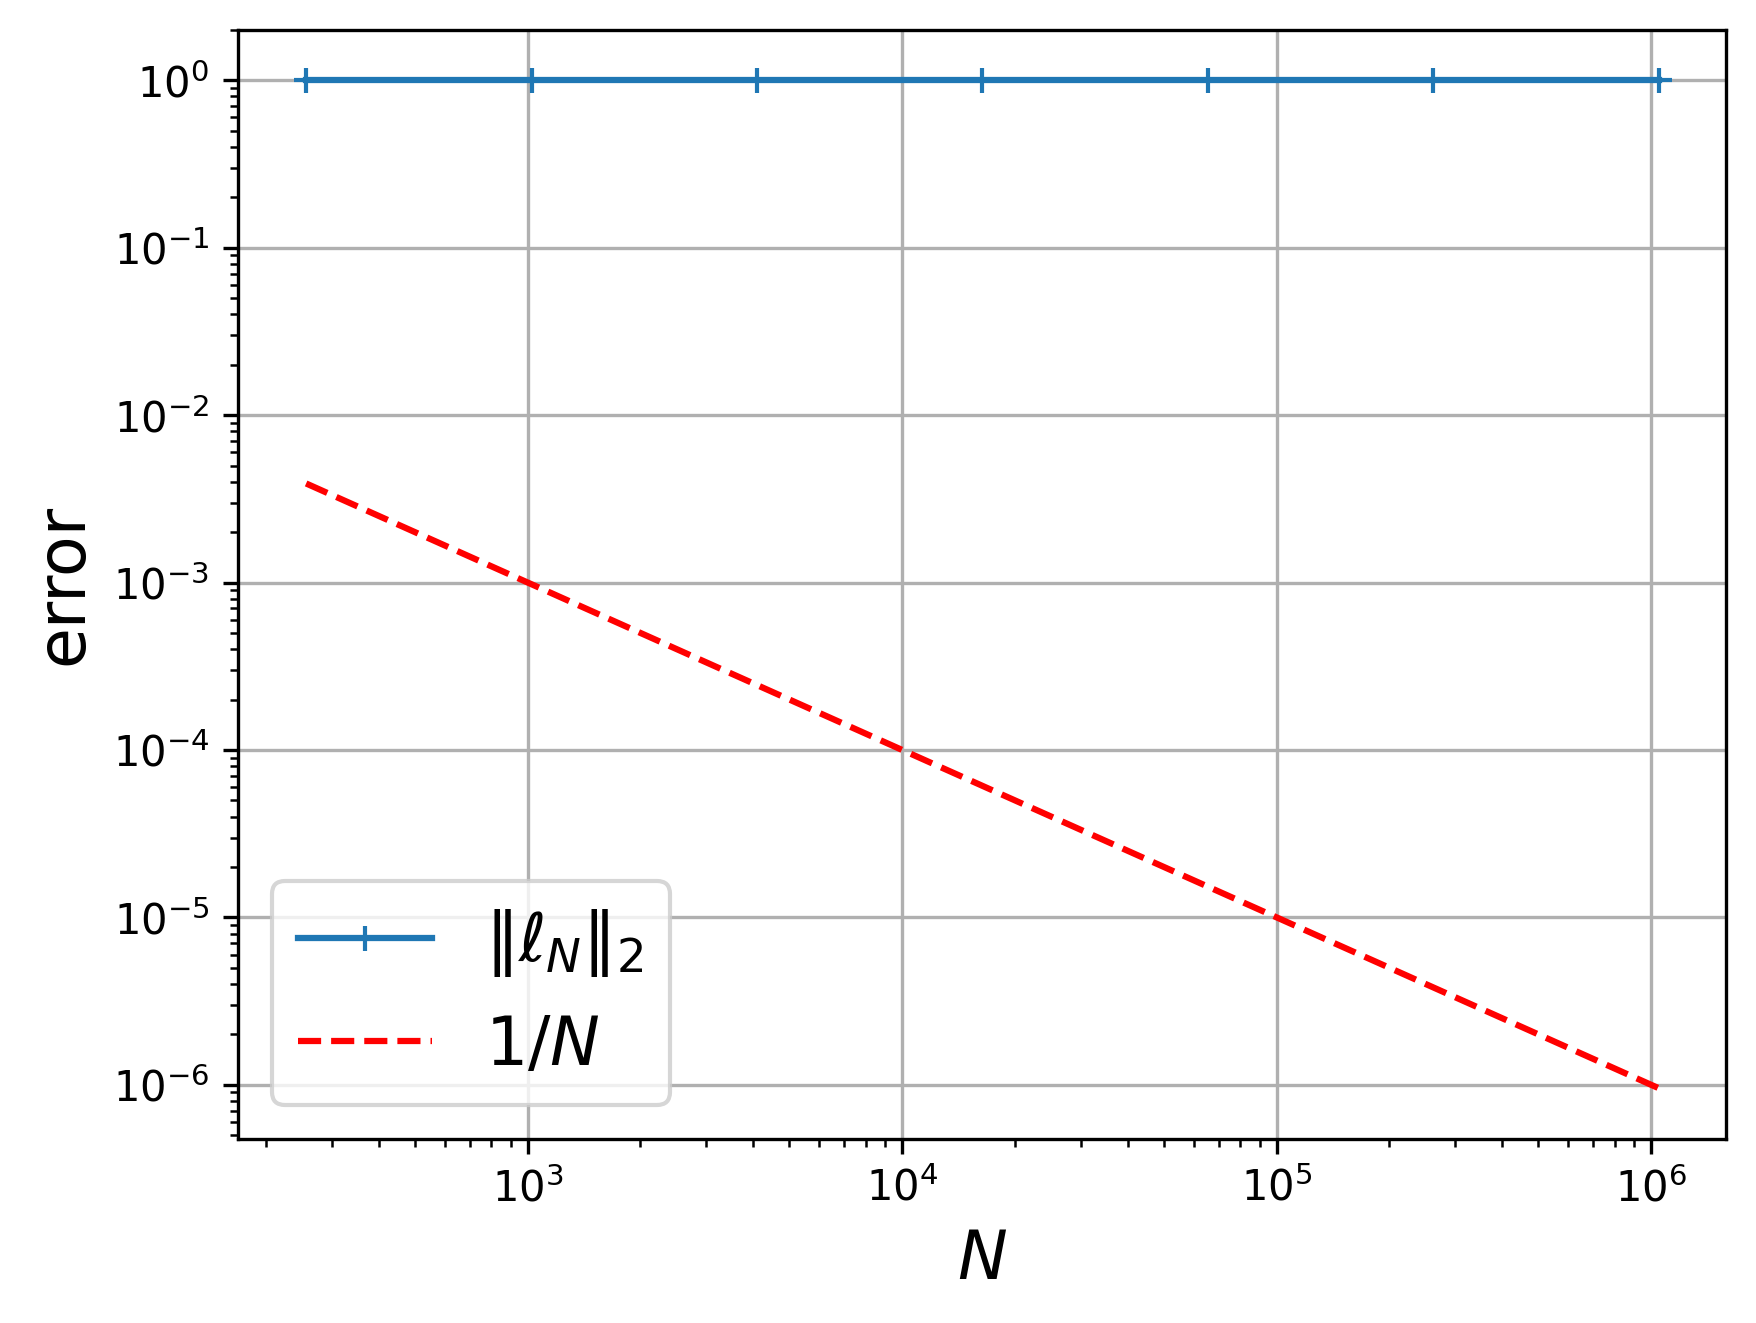

In [10]:

Ns = ns**2
plt.figure( dpi=300)
plt.loglog(Ns, error, '+-')
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel('error', fontsize=16)
order = 1
plt.plot(Ns, 1 / Ns ** order, 'r--')
plt.legend([r'$\|\ell_N\|_2$', r'$1/N$'], fontsize=16)
plt.grid()

Construct a deterministic hybrid iterative method, where $\boldsymbol{B}$ is the weighted Jacobi method,
$$
\boldsymbol{B} = \omega D^{-1}
$$
$\mathcal{H}$ is the spectral FFT operator,
$$
\mathcal{H} = F^* \Lambda F
$$

In [11]:
def him(A, b, n, tol=1e-6):
    x = np.zeros_like(b)
    norm_b = np.linalg.norm(b)
    res = 1
    omega = 3/4
    D = A.diagonal()
    ress = [1]
    while res > tol:
        for i in range(10):
            x = x + omega / D * (b - A@x)
        r = b - A@x
        e = spectralfft2d(r.reshape(n-1, n-1), n)
        x = x + omega * e.flatten()
        r = b - A@x
        res = np.linalg.norm(r) / norm_b
        ress.append(res)
    return x, np.array(ress)

/var/folders/yk/45n_4n0s1s91zp87l61tkn_00000gn/T/ipykernel_13012/3849069866.py:11: RuntimeWarning: divide by zero encountered in divide
  ik2 = 1 / (kx**2 + ky**2)  # spectral filter ||k||^{-2} on full k-grid


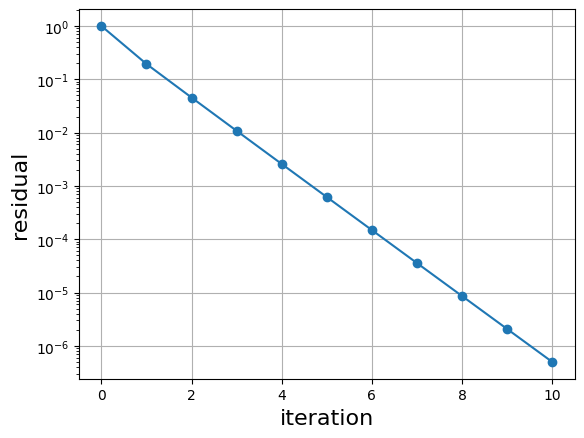

In [12]:
n = 32
A = gen_A(n-1)
b = np.random.rand(A.shape[0])
x, ress = him(A, b, n)
plt.semilogy(ress, '-o')
plt.xlabel('iteration', fontsize=16)
plt.ylabel('residual', fontsize=16)
plt.grid()

In [13]:
for n in ns:
    A = gen_A(n-1)
    b = np.random.rand(A.shape[0])
    x, ress = him(A, b, n)
    convergence_rates = ress[1:] / ress[:-1]
    asymptotic_factor = np.mean(convergence_rates[-3:])
    print("n = ", n, "needed iters = ", len(ress)-1, " asymptotic convergence factor:", asymptotic_factor)

/var/folders/yk/45n_4n0s1s91zp87l61tkn_00000gn/T/ipykernel_13012/3849069866.py:11: RuntimeWarning: divide by zero encountered in divide
  ik2 = 1 / (kx**2 + ky**2)  # spectral filter ||k||^{-2} on full k-grid


n =  16 needed iters =  9  asymptotic convergence factor: 0.21828556466923732
n =  32 needed iters =  10  asymptotic convergence factor: 0.24075011799237186
n =  64 needed iters =  10  asymptotic convergence factor: 0.24643747645433686
n =  128 needed iters =  10  asymptotic convergence factor: 0.24845233544228962
n =  256 needed iters =  10  asymptotic convergence factor: 0.2492591021593451
n =  512 needed iters =  10  asymptotic convergence factor: 0.24963641685006374
n =  1024 needed iters =  10  asymptotic convergence factor: 0.24981269233492864


### Compare with GMG

In [14]:
from scipy.sparse import coo_matrix, kron
from scipy.sparse.linalg import spsolve

In [15]:
def weighted_jacobi(A, b, x, omega=2/3, max_iter=1):
    for k in range(max_iter):
        x = x + omega * (b - A @ x) / A.diagonal()
    return x

In [16]:
def build_transfer_op(finesize):
    num_cols = finesize // 2 
    I = np.zeros(3 * num_cols, dtype=np.int32)
    J = np.zeros(3 * num_cols, dtype=np.int32)
    V = np.zeros(3 * num_cols, dtype=np.float64)
    for i in range(num_cols):
        I[3*i : 3*i+3] = [2 * i , 2 * i + 1, 2 * i + 2]
        J[3*i : 3*i+3] = i * np.ones(3, dtype=np.int32)
        V[3*i : 3*i+3] = [1.0, 2.0, 1.0]
    prolong_op = 0.5 * coo_matrix((V, (I, J)), shape=(finesize, num_cols))
    P = kron(prolong_op, prolong_op)
    R = P.transpose() / 4.0
    return P, R

In [17]:
def vcycle_setup(A, level):
    Ps = []
    Rs = []
    As = [A]
    for i in range(level):
        n = int(np.round(np.sqrt(A.shape[0])))
        P, R = build_transfer_op(n)
        A = R @ A @ P
        Ps.append(P)
        Rs.append(R)
        As.append(A)
    return Ps, Rs, As

In [18]:
def vcycle(As, Ps, Rs, b, level, max_level, relax_func, x=None):
    if x is None:
        x = np.zeros_like(b)
    A = As[level]
    if level == max_level:
        x = spsolve(A, b)
        return x
    else:
        x = relax_func(A, b, x, max_iter=3)
        r = b - A @ x
        rc = Rs[level] @ r
        ec = vcycle(As, Ps, Rs, rc, level + 1, max_level, relax_func)
        e = Ps[level] @ ec
        x = x + e
        x = relax_func(A, b, x, max_iter=3)
        return x

In [19]:
def mg_solver(A, b, N):
    level = int(np.log2(N)) - 1
    Ps, Rs, As = vcycle_setup(A, level)
    x = np.zeros_like(b)
    ress = [1]
    for i in range(100):
        x = vcycle(As, Ps, Rs, b, 0, level, weighted_jacobi, x)
        r = b - A @ x
        res = np.linalg.norm(r) / np.linalg.norm(b)
        ress.append(res)
        if res < 1e-6:
            break
    # print(f"N = {N}, level = {level+1}, iters = {len(ress)-1}")
    return x, np.array(ress)

In [20]:
N_list = [2**i - 1 for i in range(4, 11)]
for N in N_list:
    A = gen_A(N)
    h = 1/(N+1)
    b = np.random.rand(A.shape[0])
    x, ress = mg_solver(A, b, N)
    convergence_rates = ress[1:] / ress[:-1]
    asymptotic_factor = np.mean(convergence_rates[-3:])
    print("n = ", N, "needed iters = ", len(ress)-1, "asymptotic convergence factor:", asymptotic_factor)
    # plt.semilogy(ress, marker="o", label=f"N={N}")
    # plt.xlabel('Iterations', fontsize=20)
    # plt.ylabel('Relative residual', fontsize=20)
    # plt.grid()
    # plt.legend()

n =  15 needed iters =  6 asymptotic convergence factor: 0.08733082479476391
n =  31 needed iters =  6 asymptotic convergence factor: 0.09039879001466194
n =  63 needed iters =  6 asymptotic convergence factor: 0.0884686905864827
n =  127 needed iters =  6 asymptotic convergence factor: 0.08686644105341203
n =  255 needed iters =  6 asymptotic convergence factor: 0.08494262551245467
n =  511 needed iters =  6 asymptotic convergence factor: 0.08301879198958019
n =  1023 needed iters =  6 asymptotic convergence factor: 0.08174312500973176


In [21]:
import time

# n is the number of internal nodes
def FNS(A, b, n):
    return him(A, b, n+1)

def GMG(A, b, n):
    return mg_solver(A, b, n)

def generate_system(n):
    A = gen_A(n)
    b = np.random.rand(A.shape[0])
    return A, b

L = range(6, 13) 
sizes = [2**l-1 for l in L]

times_FNS = []
times_GMG = []
for n in sizes:
    A, b = generate_system(n)

    # FNS
    start_time = time.time()
    FNS(A, b, n)
    times_FNS.append((time.time() - start_time))

    # GMG
    start_time = time.time()
    GMG(A, b, n)
    times_GMG.append((time.time() - start_time))


/var/folders/yk/45n_4n0s1s91zp87l61tkn_00000gn/T/ipykernel_13012/3849069866.py:11: RuntimeWarning: divide by zero encountered in divide
  ik2 = 1 / (kx**2 + ky**2)  # spectral filter ||k||^{-2} on full k-grid


(array([1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05, 1.e+07, 1.e+09,
        1.e+11]),
 [Text(0, 1e-05, '$\\mathdefault{10^{-5}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$'),
  Text(0, 100000.0, '$\\mathdefault{10^{5}}$'),
  Text(0, 10000000.0, '$\\mathdefault{10^{7}}$'),
  Text(0, 1000000000.0, '$\\mathdefault{10^{9}}$'),
  Text(0, 100000000000.0, '$\\mathdefault{10^{11}}$')])

<Figure size 1920x1440 with 0 Axes>

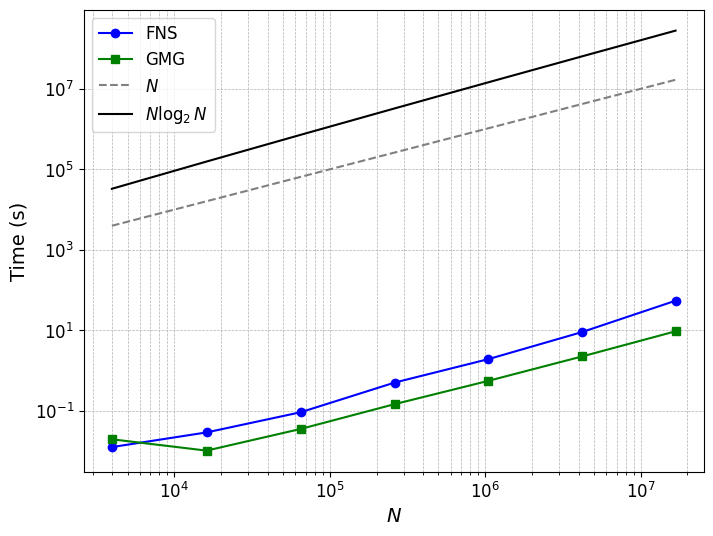

In [22]:
sizes = [2**l-1 for l in L]
sizes = np.array(sizes)**2
times_N = [n for n in sizes]
times_NlogN = [n * np.log(n) for n in sizes]

plt.figure(dpi=300)
plt.figure(figsize=(8, 6))
plt.loglog(sizes, times_FNS, label='FNS', marker='o', color='blue')
plt.loglog(sizes, times_GMG, label='GMG', marker='s', color='green')
plt.loglog(sizes, times_N, label=r'$N$', linestyle='--', color='gray')
plt.loglog(sizes, times_NlogN, label=r'$N\log_2 N$', linestyle='-', color='black')

plt.xlabel(r'$N$', fontsize=14)
plt.ylabel('Time (s)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig("FNSvsGMG.png",dpi=200,)